In [1]:
%matplotlib inline

#imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Get Data

In [2]:
label_creation_df = pd.read_csv(f'data/all_label_creations.csv')

In [3]:
# Some properties are duplicated in the CSV...
label_creation_df.drop_duplicates(inplace=True)
# Sort revisions by properties and timestamps
label_creation_df.sort_values(["property","timestamp"],inplace=True)
# Delete properties with NaN values
label_creation_df = label_creation_df.loc[~label_creation_df.language.isna()]

In [4]:
label_creation_df['rating'] = 1

In [5]:
label_creation_df.sample()

,timestamp,property,language,rating
89086,2013-10-21T12:00:34Z,P969,nl,1


In [6]:
num_languages = label_creation_df.language.nunique()
num_properties = label_creation_df.property.nunique()

print("PROPERTIES: {} LANGUAGES: {}".format(num_properties, num_languages))

PROPERTIES: 5126 LANGUAGES: 234


In [7]:
# Normalize in [0, 1]

#r = df['rating'].values.astype(float)
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(r.reshape(-1,1))
#df_normalized = pd.DataFrame(x_scaled)
#df['rating'] = df_normalized

In [8]:
label_creation_df.sample()

,timestamp,property,language,rating
66867,2013-10-12T17:13:46Z,P463,lb,1


In [9]:
# Convert DataFrame in user-item matrix

matrix = label_creation_df.pivot_table(index='property', columns='language', values='rating')
matrix.fillna(0, inplace=True)

# Users and items ordered as they are in matrix

properties = matrix.index.tolist()
languages = matrix.columns.tolist()

matrix = matrix.as_matrix()
#matrix = matrix.values()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [10]:
# Network Parameters

num_input = num_languages
num_hidden_1 = 30
num_hidden_2 = 10

X = tf.placeholder(tf.float64, [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1], dtype=tf.float64)),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2], dtype=tf.float64)),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1], dtype=tf.float64)),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input], dtype=tf.float64)),
}

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2], dtype=tf.float64)),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'decoder_b2': tf.Variable(tf.random_normal([num_input], dtype=tf.float64)),
}

In [11]:
# Building the encoder

def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2


# Building the decoder

def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2


# Construct model

encoder_op = encoder(X)
decoder_op = decoder(encoder_op)


# Prediction

y_pred = decoder_op


# Targets are the input data.

y_true = X

In [12]:
# Define loss and optimizer, minimize the squared error

loss = tf.losses.mean_squared_error(y_true, y_pred)
optimizer = tf.train.RMSPropOptimizer(0.03).minimize(loss)

predictions = pd.DataFrame()

# Define evaluation metrics

eval_x = tf.placeholder(tf.int32, )
eval_y = tf.placeholder(tf.int32, )
pre, pre_op = tf.metrics.precision(labels=eval_x, predictions=eval_y)

In [13]:
# Initialize the variables (i.e. assign their default value)

init = tf.global_variables_initializer()
local_init = tf.local_variables_initializer()

In [14]:
with tf.Session() as session:
    epochs = 100
    batch_size = 25

    session.run(init)
    session.run(local_init)

    num_batches = int(matrix.shape[0] / batch_size)
    matrix = np.array_split(matrix, num_batches)

    for i in range(epochs):

        avg_cost = 0

        for batch in matrix:
            _, l = session.run([optimizer, loss], feed_dict={X: batch})
            avg_cost += l

        avg_cost /= num_batches

        #print("Epoch: {} Loss: {}".format(i + 1, avg_cost))

    print("Predictions...")

    matrix_copy = np.concatenate(matrix, axis=0)

    preds = session.run(decoder_op, feed_dict={X: matrix_copy})

    predictions = predictions.append(pd.DataFrame(preds))

    predictions = predictions.stack().reset_index(name='rating')
    predictions.columns = ['property', 'language','rating']
    predictions['property'] = predictions['property'].map(lambda value: properties[value])
    predictions['language'] = predictions['language'].map(lambda value: languages[value])

Predictions...


In [15]:
predictions = predictions.sort_values(by=['rating'],ascending=False)

In [16]:
rrr = label_creation_df.pivot_table(index='property', columns='language', values='rating')
rrr.fillna(0, inplace=True)
rrr= pd.DataFrame(rrr.unstack())
rrr.reset_index(inplace=True)
rrr.columns = [ 'language','property','actual_rating']

In [17]:
aaa = pd.merge(predictions,rrr,how='inner',left_on=['property','language'],right_on=['property','language'])

# Show the prediction distribution

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


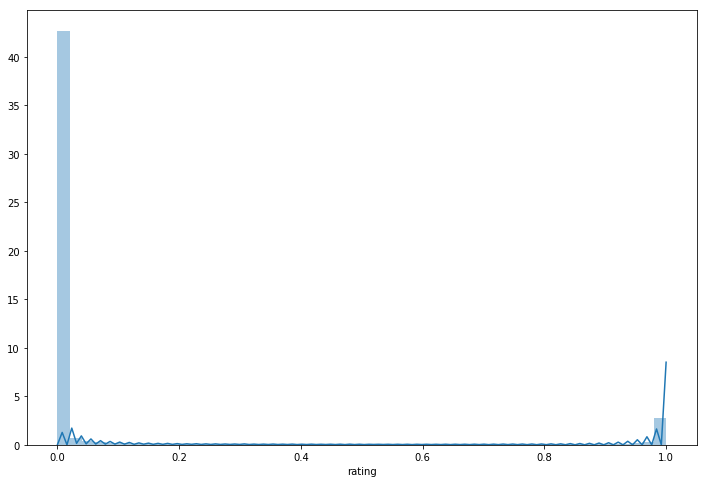

In [18]:
plt.figure(figsize=(12,8))
sns.distplot(aaa.rating)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


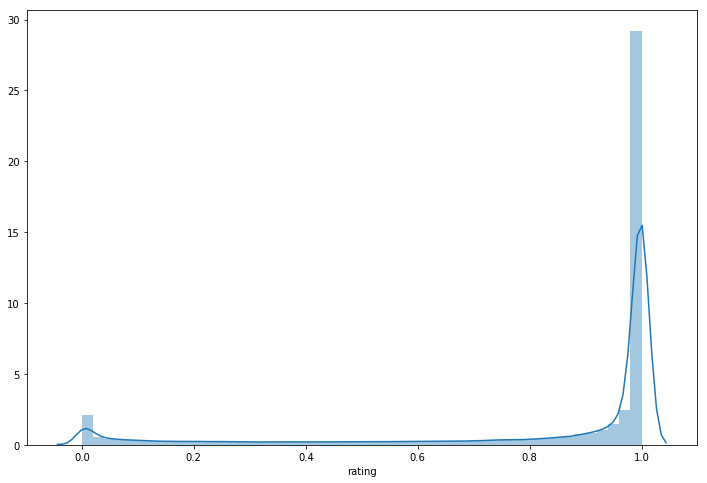

In [19]:
plt.figure(figsize=(12,8))
sns.distplot(aaa.loc[aaa.actual_rating == 1,'rating'])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


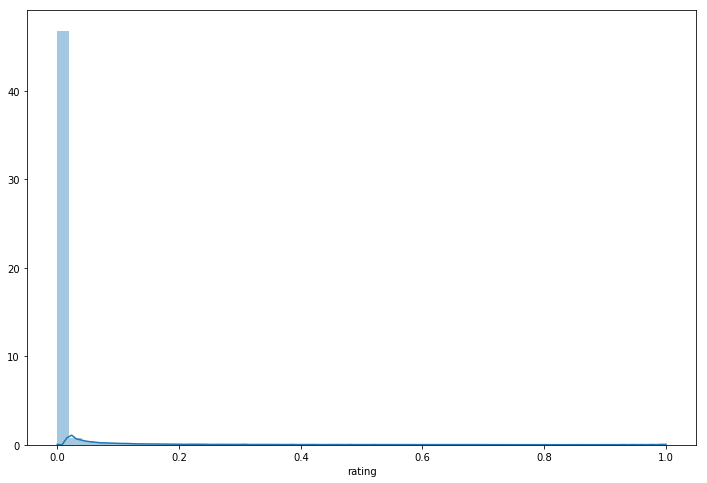

In [20]:
plt.figure(figsize=(12,8))
sns.distplot(aaa.loc[aaa.actual_rating == 0,'rating'])

# Show the prediction

In [22]:
pd.options.display.float_format = '{:,.4f}'.format
aaa.loc[(aaa.actual_rating == 0)
        & (aaa.rating < 1)
        & (~aaa.language.isin(['fr',]))]

,property,language,rating,actual_rating
519,P4010,de,1.0000,0.0000
2073,P2335,de,1.0000,0.0000
2118,P2336,de,1.0000,0.0000
2258,P3047,es,1.0000,0.0000
2263,P4227,zh-hans,1.0000,0.0000
3191,P3069,de,1.0000,0.0000
3522,P2225,zh-hans,1.0000,0.0000
3703,P913,zh-hans,1.0000,0.0000
4903,P1900,uk,1.0000,0.0000
4904,P2005,uk,1.0000,0.0000
